# CAPSTONE PROJECT - REE Daily Generation Forecasting (Top-7 technologies)

1) Load the prepared panel dataset (unique_id, ds, y)
2) Time split into Train/Validation/Test (last 31 + 31 days)
3) Train and evaluate several model families:
    - Baselines (naive, moving average)
    - Statistical (AutoARIMA)
    - Machine Learning (MLForecast with different feature sets)
    - Deep Learning (NeuralForecast: NBEATS, NLinear)
4) Select best model per family on Validation (MAE)

5) Visualize performance on total generation (sum over technologies)
6) Fit the best overall (non-baseline if baseline wins) on all data
7) Forecast January 2026 + simple 95% prediction intervals
8) Save the metrics and predictions to /data/metrics and /data/predictions

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA

from mlforecast import MLForecast
from mlforecast.lag_transforms import RollingMean, ExpandingMean

from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATS, NLinear

c:\Users\Admin\Desktop\UNIDATOS\tercero\AUSTRIA\TIMS\Spanish-Forecasters-MireiaMontoya-EnriqueRuiz\.venv310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2026-01-23 09:25:29,352	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2026-01-23 09:25:30,201	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Below here, we can find the variables we are going to use along the forecast pipeline for each method and algorithm. We also have the paths to save all the results we obtain.

In [2]:
H = 31 #forecast horizon for validation and test (31 days each)
TOP_K_SERIES = 7  #the top 7 technologies by mean daily generation
RANDOM_SEED = 4232

MOVING_AVG_WINDOW = 7  #baseline, the average of last 7 days
ARIMA_SEASON = 7 #weekly seasonality for daily data
SEASONAL_NAIVE_SEASONS = [7, 365] # weekly + yearly

# ML feature sets
ML_LAGS = [1, 2, 7, 14, 30, 365]
ML_DATE_FEATURES = ["dayofweek", "month", "day"]

# Neural models
NEURAL_INPUT_SIZE = 90
NEURAL_MAX_STEPS = 2000

# Output folders
OUT_PRED_DIR = Path("data/predictions")
OUT_METRICS_DIR = Path("data/metrics")
OUT_PRED_DIR.mkdir(parents=True, exist_ok=True)
OUT_METRICS_DIR.mkdir(parents=True, exist_ok=True)


Then we define some helper functions to evaluate model perfomance in a consistent way. We compute standard error metrics (MAE, RMSE and R2) together with percentage-based metrcs (MAPE and OPE). 

The *add_result* function calculates these metrics for each model, technology and data split, while *evaluate_model* applies the same evaluation procedure to both the validation and test sets. Finally, *best_model_per_family* selects the best-performing model within each family based on the lowest MAE on the validation set. 

In [3]:
def mape(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    eps = 1e-9
    return np.mean(np.abs((y_true - y_pred) / (y_true + eps))) * 100

def ope(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    return (np.sum(np.abs(y_true - y_pred)) / (np.sum(y_true) + 1e-9)) * 100

def add_result(rows, unique_id, family, model, implementation, split, y_true, y_pred):
    # Ensure predictions and true values have the same length before computing metrics
    n = min(len(y_true), len(y_pred))
    if n == 0:
        return

    y_true = np.asarray(y_true[:n])
    y_pred = np.asarray(y_pred[:n])

    # Calculate the r2 only if all thhe real values aren't the same, if not we use Nan
    r2 = r2_score(y_true, y_pred) if np.unique(y_true).size > 1 else np.nan

    rows.append({
        "unique_id": unique_id,
        "family": family,
        "model": model,
        "implementation": implementation,
        "split": split,
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAPE": mape(y_true, y_pred),
        "OPE": ope(y_true, y_pred),
        "R2": r2,
    })

def evaluate_model(rows, unique_id, family, model, implementation,
                   y_val_true, y_val_pred, y_test_true, y_test_pred):
    add_result(rows, unique_id, family, model, implementation, "val",  y_val_true,  y_val_pred)
    add_result(rows, unique_id, family, model, implementation, "test", y_test_true, y_test_pred)

def best_model_per_family(val_results):
    g = (val_results
         .groupby(["family", "model", "implementation"], as_index=False)
         .agg(MAE=("MAE", "mean")))
    best_rows = g.loc[g.groupby("family")["MAE"].idxmin()]
    return best_rows.set_index("family")["model"].to_dict()


# 1. Load the prepared dataset
At first, there was 8 datasets(csv), 1 per year (2018-2025), but then we joined then and we preprocess the data:

We prepared the parquet file, is a clean panel with:
- columns [unique_id, ds, y]
- the top-7 technologies
- full daily date grid
- the missing values filled with (ffill/bfill)

In [4]:
PANEL_PATH = Path("data/processed/ree_panel_top7.parquet")

df_panel = pd.read_parquet(PANEL_PATH)
df_panel["ds"] = pd.to_datetime(df_panel["ds"])
df_panel = df_panel.sort_values(["unique_id", "ds"]).reset_index(drop=True)

print("Loaded panel:", df_panel.shape)
print("Series:", df_panel["unique_id"].nunique())
print("Date range:", df_panel["ds"].min(), "->", df_panel["ds"].max())
print("Unique IDs:", df_panel["unique_id"].unique())


Loaded panel: (20454, 3)
Series: 7
Date range: 2018-01-01 00:00:00 -> 2025-12-31 00:00:00
Unique IDs: ['Carbón' 'Ciclo combinado' 'Cogeneración' 'Eólica' 'Hidráulica' 'Nuclear'
 'Solar fotovoltaica']


# 2. Time split (Train/Validation/Test)

We use the last 31 days as Test, the previous 31 days as Validation and everything before that as Train.


In [5]:
all_days = np.sort(df_panel["ds"].unique())

test_days  = all_days[-H:]
val_days   = all_days[-2 * H:-H]
train_days = all_days[:-2 * H]

df_train = df_panel[df_panel["ds"].isin(train_days)].copy()
df_val   = df_panel[df_panel["ds"].isin(val_days)].copy()
df_test  = df_panel[df_panel["ds"].isin(test_days)].copy()

print("Train:", df_train["ds"].min(),"->", df_train["ds"].max(), "n =", len(df_train))
print("Val:", df_val["ds"].min(),"->", df_val["ds"].max(),   "n =", len(df_val))
print("Test:", df_test["ds"].min(),"->", df_test["ds"].max(),  "n =", len(df_test))

Train: 2018-01-01 00:00:00 -> 2025-10-30 00:00:00 n = 20020
Val: 2025-10-31 00:00:00 -> 2025-11-30 00:00:00 n = 217
Test: 2025-12-01 00:00:00 -> 2025-12-31 00:00:00 n = 217


# 3. Model training and evaluation
For each technology (unique_id), we:
- Train models on Train
- Predict Validation
- Train on Train+Val
- Predict Test
- Store all metrics in a table for comparison


We start with several baseline models (naive, moving average and seasonal naive) and a statistical model, AutoARIMA. 

In [6]:
results = []
unique_ids = df_panel["unique_id"].unique()

#Baselines
for uid in unique_ids:
    # Select only one technology and sort by date 
    dm = df_panel[df_panel["unique_id"] == uid].sort_values("ds")

    # Select the values for the train/val/test
    y_train = dm[dm["ds"].isin(train_days)]["y"].values
    y_val_true  = dm[dm["ds"].isin(val_days)]["y"].values
    y_test_true = dm[dm["ds"].isin(test_days)]["y"].values

    # Baselines
    # Naive: repeat the last value
    y_val_pred = np.repeat(y_train[-1], len(y_val_true))
    y_test_pred = np.repeat(y_val_true[-1], len(y_test_true))

    evaluate_model(
        results,
        uid, "baseline", 
        "naive", 
        "numpy",
        y_val_true, 
        y_val_pred, 
        y_test_true, 
        y_test_pred)

    # Moving Average: mean of the last 7 train values and for Test, use last 7 Val values
    w = min(MOVING_AVG_WINDOW, len(y_train)) # window of selected values for the train 
    y_val_pred = np.repeat(np.mean(y_train[-w:]), len(y_val_true))

    w2 = min(MOVING_AVG_WINDOW, len(y_val_true)) # window of selected values for the test 
    y_test_pred = np.repeat(np.mean(y_val_true[-w2:]), len(y_test_true))

    evaluate_model(
        results, 
        uid, 
        "baseline", 
        f"moving_avg_{MOVING_AVG_WINDOW}",
        "numpy",
        y_val_true,
        y_val_pred,
        y_test_true,
        y_test_pred)
    
    # Seasonal Naive: yhat[t] = y[t-s]
    for s in SEASONAL_NAIVE_SEASONS:
        # VAL: repeat last s days from TRAIN
        s_train = min(s, len(y_train))
        y_val_pred = np.resize(y_train[-s_train:], len(y_val_true))

        # TEST: repeat last s days from VAL TRUE
        s_val = min(s, len(y_val_true))
        y_test_pred = np.resize(y_val_true[-s_val:], len(y_test_true))

        evaluate_model(
            results,
            uid,
            "baseline",
            f"seasonal_naive_{s}",
            "numpy",
            y_val_true,
            y_val_pred,
            y_test_true,
            y_test_pred
        )

# StatsForecast: AutoARIMA
sf = StatsForecast(
    models=[AutoARIMA(season_length=ARIMA_SEASON, stepwise=True, approximation=True)],
    freq="D",
)

# Fit on train -> predict Validation
sf.fit(df_train, id_col="unique_id", time_col="ds", target_col="y")
preds_val_arima = sf.predict(h=H)

df_train_val = df_panel[df_panel["ds"].isin(np.concatenate([train_days, val_days]))].copy()

# Fit on Train + Val -> predict Test
sf.fit(df_train_val, id_col="unique_id", time_col="ds", target_col="y")
preds_test_arima = sf.predict(h=H)

# For each tehnoloy we get the ARIMA predictions
for uid in unique_ids:
    y_val_true  = df_val[df_val["unique_id"] == uid].sort_values("ds")["y"].values
    y_test_true = df_test[df_test["unique_id"] == uid].sort_values("ds")["y"].values

    pv = preds_val_arima[preds_val_arima["unique_id"] == uid].sort_values("ds")["AutoARIMA"].values
    pt = preds_test_arima[preds_test_arima["unique_id"] == uid].sort_values("ds")["AutoARIMA"].values

    evaluate_model(
        results, 
        uid, 
        "statistical", 
        "AutoARIMA",
        "statsforecast",
        y_val_true,
        pv, 
        y_test_true,
        pt)



c:\Users\Admin\Desktop\UNIDATOS\tercero\AUSTRIA\TIMS\Spanish-Forecasters-MireiaMontoya-EnriqueRuiz\.venv310\lib\site-packages\statsforecast\arima.py:486: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
c:\Users\Admin\Desktop\UNIDATOS\tercero\AUSTRIA\TIMS\Spanish-Forecasters-MireiaMontoya-EnriqueRuiz\.venv310\lib\site-packages\statsforecast\arima.py:486: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
c:\Users\Admin\Desktop\UNIDATOS\tercero\AUSTRIA\TIMS\Spanish-Forecasters-MireiaMontoya-EnriqueRuiz\.venv310\lib\site-packages\statsforecast\arima.py:486: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
c:\Users\Admin\Desktop\UNIDATOS\tercero\AUSTRIA\TIMS\Spanish-Forecasters-MireiaMontoya-EnriqueRuiz\.venv310\lib\site-packages\statsforecast\arima.py:486: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
c:\Users\Admin\Desktop\UNIDATOS\tercero\AUSTRIA\TIMS\Spa

Now we do the Machine Learning models: MLForecast with lags only, lags + calendar features and lags + statistical transforms

In [7]:
# MLForecast
# We test 3 feature sets:
# lags only, 
# lags + calendar features (dayofweek/month/day)
# lags + statistical transforms (rolling mean, expanding mean)

ml_models = [
    RandomForestRegressor(n_estimators=600, random_state=RANDOM_SEED),
    GradientBoostingRegressor(random_state=RANDOM_SEED),
]

# Lag only
fcst_lag = MLForecast(
    models=ml_models, 
    freq="D", 
    lags=ML_LAGS)

fcst_lag.fit(df_train, id_col="unique_id", time_col="ds", target_col="y")
preds_val_ml_lag = fcst_lag.predict(h=H)

fcst_lag.fit(df_train_val, id_col="unique_id", time_col="ds", target_col="y")
preds_test_ml_lag = fcst_lag.predict(h=H)

# lag + calendar features 
fcst_cal = MLForecast(
    models=ml_models, 
    freq="D", 
    lags=ML_LAGS, 
    date_features=ML_DATE_FEATURES)

fcst_cal.fit(df_train, id_col="unique_id", time_col="ds", target_col="y")
preds_val_ml_cal = fcst_cal.predict(h=H)

fcst_cal.fit(df_train_val, id_col="unique_id", time_col="ds", target_col="y")
preds_test_ml_cal = fcst_cal.predict(h=H)

# lag + statistical 
lag_transforms = {
    1:  [ExpandingMean()],
    7:  [RollingMean(window_size=7)],
    14: [RollingMean(window_size=14)],
    30:  [RollingMean(window_size=30)],
    365: [RollingMean(window_size=7)]
}
fcst_stat = MLForecast(
    models=ml_models, 
    freq="D", 
    lags=ML_LAGS, 
    lag_transforms=lag_transforms)

fcst_stat.fit(df_train, id_col="unique_id", time_col="ds", target_col="y")
preds_val_ml_stat = fcst_stat.predict(h=H)

fcst_stat.fit(df_train_val, id_col="unique_id", time_col="ds", target_col="y")
preds_test_ml_stat = fcst_stat.predict(h=H)

ml_pred_sets = [
    ("lag", preds_val_ml_lag, preds_test_ml_lag),
    ("lag+calendar", preds_val_ml_cal, preds_test_ml_cal),
    ("lag+statistical", preds_val_ml_stat, preds_test_ml_stat),
]

# Columns where we have the predictions 
ml_model_names = ["RandomForestRegressor", "GradientBoostingRegressor"]

for uid in unique_ids:
    y_val_true  = df_val[df_val["unique_id"] == uid].sort_values("ds")["y"].values
    y_test_true = df_test[df_test["unique_id"] == uid].sort_values("ds")["y"].values

    # iter for each feature 
    for fset, pv_df, pt_df in ml_pred_sets:
        pv = pv_df[pv_df["unique_id"] == uid].sort_values("ds")
        pt = pt_df[pt_df["unique_id"] == uid].sort_values("ds")

        # iter for both algorithms RandomForestRegressor and GradientBoostingregressor
        for mname in ml_model_names:
            
            evaluate_model(
                results,
                uid, 
                "ml",
                f"{mname}__{fset}", 
                "mlforecast_sklearn",
                y_val_true, 
                pv[mname].values, 
                y_test_true, 
                pt[mname].values
            )

NeuralForecast, we try the NBEATS and the NLinear algorithms.

In [8]:
# NeuralForecast (NBEATS + NLinear)
dl_models = [
    NBEATS(h=H, input_size=NEURAL_INPUT_SIZE, max_steps=NEURAL_MAX_STEPS, random_seed=RANDOM_SEED),
    NLinear(h=H, input_size=NEURAL_INPUT_SIZE, max_steps=NEURAL_MAX_STEPS, random_seed=RANDOM_SEED),
]
nf = NeuralForecast(models=dl_models, freq="D")

nf.fit(df_train, id_col="unique_id", time_col="ds", target_col="y")
preds_val_dl = nf.predict()

nf.fit(df_train_val, id_col="unique_id", time_col="ds", target_col="y")
preds_test_dl = nf.predict()

for uid in unique_ids:
    y_val_true  = df_val[df_val["unique_id"] == uid].sort_values("ds")["y"].values
    y_test_true = df_test[df_test["unique_id"] == uid].sort_values("ds")["y"].values

    pv = preds_val_dl[preds_val_dl["unique_id"] == uid].sort_values("ds")
    pt = preds_test_dl[preds_test_dl["unique_id"] == uid].sort_values("ds")

    for mname in ["NBEATS", "NLinear"]:
        evaluate_model(
            results, 
            uid,
            "neural",
            mname,
            "neuralforecast",
            y_val_true, 
            pv[mname].values, 
            y_test_true, 
            pt[mname].values)


Seed set to 4232
Seed set to 4232
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.6 M  | train
-------------------------------------------------------
2.6 M     Trainable params
7.6 K     Non-trainable params
2.6 M     Total params
10.552    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00,  4.21it/s, v_num=32, train_loss_step=5.540, train_loss_epoch=5.540]

`Trainer.fit` stopped: `max_steps=2000` reached.


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00,  4.21it/s, v_num=32, train_loss_step=5.540, train_loss_epoch=5.540]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | linear       | Linear        | 2.8 K  | train
-------------------------------------------------------
2.8 K     Trainable params
0         Non-trainable params
2.8 K     Total params
0.011     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode



Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 25.66it/s, v_num=33, train_loss_step=24.40, train_loss_epoch=24.40]  

`Trainer.fit` stopped: `max_steps=2000` reached.


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 25.66it/s, v_num=33, train_loss_step=24.40, train_loss_epoch=24.40]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 67.53it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 375.97it/s]

GPU available: False, used: False


TPU available: False, using: 0 TPU cores

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.6 M  | train
-------------------------------------------------------
2.6 M     Trainable params
7.6 K     Non-trainable params
2.6 M     Total params
10.552    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00,  3.94it/s, v_num=36, train_loss_step=3.520, train_loss_epoch=3.520]

`Trainer.fit` stopped: `max_steps=2000` reached.


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00,  3.94it/s, v_num=36, train_loss_step=3.520, train_loss_epoch=3.520]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | linear       | Linear        | 2.8 K  | train
-------------------------------------------------------
2.8 K     Trainable params
0         Non-trainable params
2.8 K     Total params
0.011     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode



Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 20.43it/s, v_num=37, train_loss_step=24.10, train_loss_epoch=24.10]

`Trainer.fit` stopped: `max_steps=2000` reached.


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 20.43it/s, v_num=37, train_loss_step=24.10, train_loss_epoch=24.10]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.08it/s] 


GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 270.84it/s]


# 4. Result table and Model selection
We save: 
- metrics_all.csv: one row per technology, mocel, split
- metrics_summary.csv: avverage metrics per model family/split

Model choice:
- Best per family = lowest MAE on Validation
- Best overall = lowest average MAE on validation across technologies

In [9]:
results_df = pd.DataFrame(results)
results_df.to_csv(OUT_METRICS_DIR / "metrics_all.csv", index=False)

summary_df = (
    results_df.groupby(["family", "model", "implementation", "split"], as_index=False)
    .agg({"MAE": "mean", "RMSE": "mean", "MAPE": "mean", "OPE": "mean", "R2": "mean"})
)

# save a summary agg per model 
summary_df.to_csv(OUT_METRICS_DIR / "metrics_summary.csv", index=False)

# Select the best model per family (validation)
val_results = results_df[results_df["split"] == "val"].copy()
best_models = best_model_per_family(val_results)

print("Best per family (by MAE on validation):")
print(best_models)

# Best global model 
avg_val = (
    val_results.groupby(["family", "model", "implementation"], as_index=False)
    .agg({"MAE": "mean"})
    .sort_values("MAE")
)
best_overall = avg_val.iloc[0]

print("Best OVERALL (by val MAE):", dict(best_overall))

# For the FINAL forecast, if a baseline wins, we choose the best non-baseline model
final_choice = best_overall
if best_overall["family"] == "baseline":
    final_choice = avg_val[avg_val["family"] != "baseline"].iloc[0]
    print("Baseline was best, but FINAL forecast uses best non-baseline:", dict(final_choice))
else:
    print("FINAL forecast uses:", dict(final_choice))


Best per family (by MAE on validation):
{'baseline': 'naive', 'ml': 'RandomForestRegressor__lag', 'neural': 'NLinear', 'statistical': 'AutoARIMA'}
Best OVERALL (by val MAE): {'family': 'ml', 'model': 'RandomForestRegressor__lag', 'implementation': 'mlforecast_sklearn', 'MAE': 27.070759252788033}
FINAL forecast uses: {'family': 'ml', 'model': 'RandomForestRegressor__lag', 'implementation': 'mlforecast_sklearn', 'MAE': 27.070759252788033}


# 6. Visuals

Now we proced with the visual part; plots, results, etc. 


TOTAL MAE ranking (VAL): [('neural', 60.69527055632561), ('baseline', 64.54551345161289), ('ml', 73.82753968682786), ('statistical', 83.21889062355272)]
BEST TOTAL (VAL): ('neural', 60.69527055632561)

TOTAL MAE ranking (TEST): [('statistical', 50.17902495811114), ('baseline', 52.761887193548404), ('neural', 55.44816783707156), ('ml', 60.0405019239248)]
BEST TOTAL (TEST): ('statistical', 50.17902495811114)
FINAL family for Jan 2026 forecast (based on TOTAL validation): neural


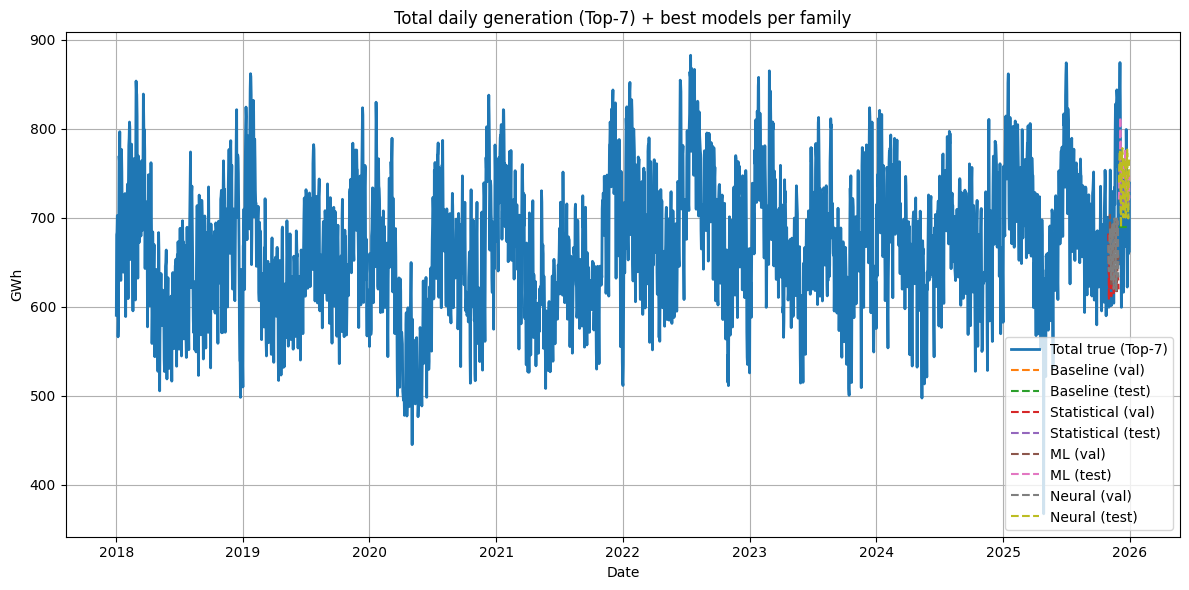

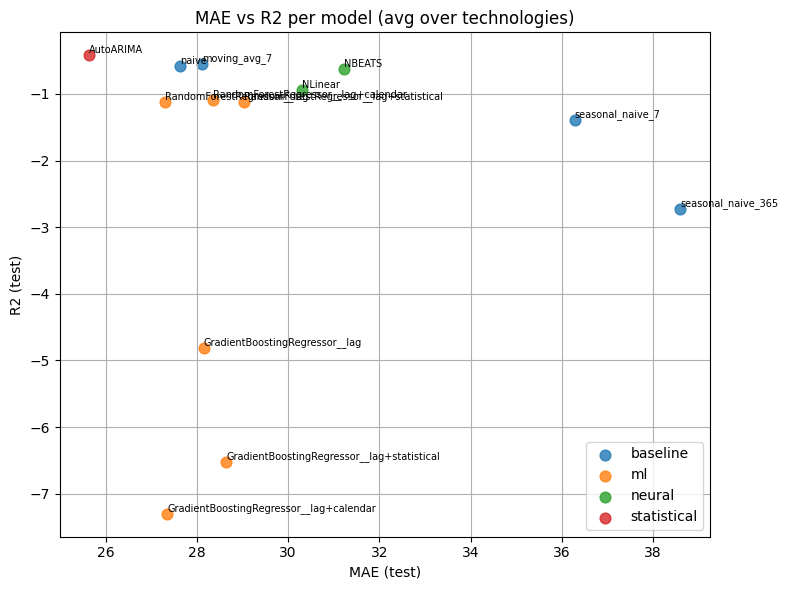

In [10]:
# Visuals 
total_series = df_panel.groupby("ds")["y"].sum()
total_train = total_series[total_series.index.isin(train_days)]
total_val   = total_series[total_series.index.isin(val_days)]
total_test  = total_series[total_series.index.isin(test_days)]

val_dates  = total_val.index.values
test_dates = total_test.index.values

# compose total predictions for best model per family 
total_pred_val = {}
total_pred_test = {}

# baseline
b = best_models.get("baseline", None)

if b == "naive":
    total_pred_val["baseline"]  = np.repeat(total_train.values[-1], len(val_dates))
    total_pred_test["baseline"] = np.repeat(total_val.values[-1], len(test_dates))

elif b == f"moving_avg_{MOVING_AVG_WINDOW}":
    total_pred_val["baseline"]  = np.repeat(total_train.values[-MOVING_AVG_WINDOW:].mean(), len(val_dates))
    total_pred_test["baseline"] = np.repeat(total_val.values[-MOVING_AVG_WINDOW:].mean(), len(test_dates))

elif b.startswith("seasonal_naive_"):
    s = int(b.split("_")[-1])
    last_s_train_total = total_train.values[-min(s, len(total_train)):]
    total_pred_val["baseline"]  = np.resize(last_s_train_total, len(val_dates))

    last_s_val_total = total_val.values[-min(s, len(total_val)):]
    total_pred_test["baseline"] = np.resize(last_s_val_total, len(test_dates))
# statistical
if "statistical" in best_models:
    total_pred_val["statistical"]  = preds_val_arima.groupby("ds")[best_models["statistical"]].sum().values
    total_pred_test["statistical"] = preds_test_arima.groupby("ds")[best_models["statistical"]].sum().values

# ML
if "ml" in best_models:
    col = best_models["ml"]
    base_model = col.split("__")[0]
    
    if "__lag+calendar" in col:
        pv_df, pt_df = preds_val_ml_cal, preds_test_ml_cal
    
    elif "__lag+statistical" in col:
        pv_df, pt_df = preds_val_ml_stat, preds_test_ml_stat
    
    else:
        pv_df, pt_df = preds_val_ml_lag, preds_test_ml_lag

    total_pred_val["ml"]  = pv_df.groupby("ds")[base_model].sum().values
    total_pred_test["ml"] = pt_df.groupby("ds")[base_model].sum().values

# Neural
if "neural" in best_models:
    col = best_models["neural"]
    total_pred_val["neural"]  = preds_val_dl.groupby("ds")[col].sum().values
    total_pred_test["neural"] = preds_test_dl.groupby("ds")[col].sum().values
    
def rank_families_on_total(y_true, pred_dict):
    ranking = []
    for fam, yhat in pred_dict.items():
        ranking.append((fam, mean_absolute_error(y_true, yhat)))
    ranking.sort(key=lambda x: x[1])  # less MAE = best
    return ranking

rank_val_total  = rank_families_on_total(total_val.values,  total_pred_val)
rank_test_total = rank_families_on_total(total_test.values, total_pred_test)

print("\nTOTAL MAE ranking (VAL):", rank_val_total)
print("BEST TOTAL (VAL):", rank_val_total[0])

print("\nTOTAL MAE ranking (TEST):", rank_test_total)
print("BEST TOTAL (TEST):", rank_test_total[0])

best_total_family = rank_val_total[0][0]
print("FINAL family for Jan 2026 forecast (based on TOTAL validation):", best_total_family)
    
# Plots
plt.figure(figsize=(12, 6))
plt.plot(total_series.index, total_series.values, label="Total true (Top-7)", linewidth=2)

name_map = {"baseline": "Baseline", "statistical": "Statistical", "ml": "ML", "neural": "Neural"}

for fam in ["baseline", "statistical", "ml", "neural"]:
    if fam in total_pred_val:
        plt.plot(val_dates, total_pred_val[fam], "--", label=f"{name_map[fam]} (val)")
        plt.plot(test_dates, total_pred_test[fam], "--", label=f"{name_map[fam]} (test)")

plt.title("Total daily generation (Top-7) + best models per family")
plt.xlabel("Date")
plt.ylabel("GWh")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# MAE vs R2 scatter (test)
test_results = results_df[results_df["split"] == "test"].copy()
agg = test_results.groupby(["family", "model"], as_index=False).agg({"MAE": "mean", "R2": "mean"})

plt.figure(figsize=(8, 6))
for fam in agg["family"].unique():
    sub = agg[agg["family"] == fam]
    plt.scatter(sub["MAE"], sub["R2"], label=fam, s=60, alpha=0.8)
    for _, row in sub.iterrows():
        plt.text(row["MAE"], row["R2"], row["model"], fontsize=7, ha="left", va="bottom")

plt.xlabel("MAE (test)")
plt.ylabel("R2 (test)")
plt.title("MAE vs R2 per model (avg over technologies)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

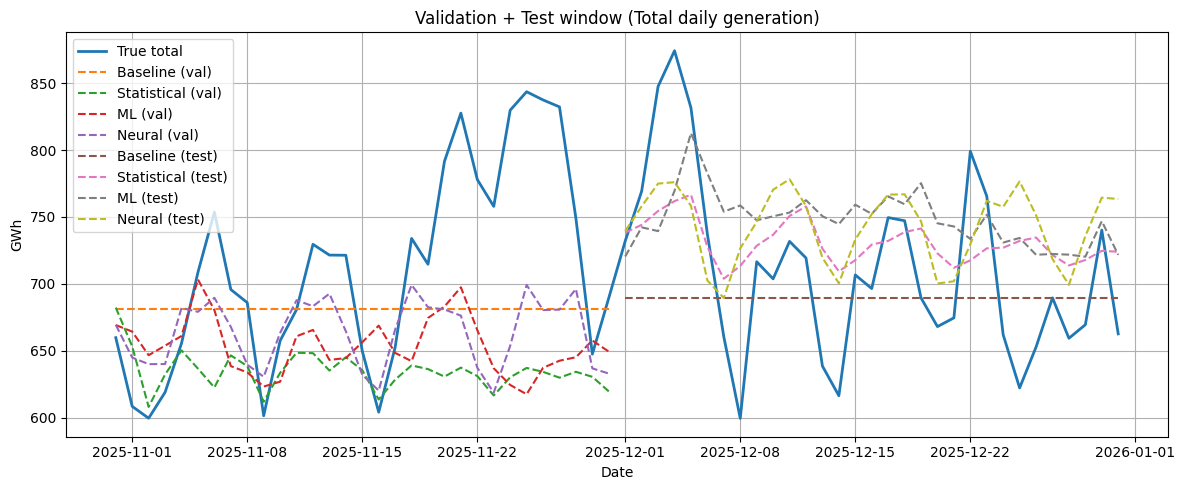

In [11]:
#Plot only VAL + TEST (total)
total = df_panel.groupby("ds")["y"].sum()

plot_start = pd.to_datetime(val_days[0])
plot_end   = pd.to_datetime(test_days[-1])

val_dates  = pd.to_datetime(val_days)
test_dates = pd.to_datetime(test_days)

plt.figure(figsize=(12,5))

plt.plot(total.loc[plot_start:plot_end], label="True total", linewidth=2)

# Predictions (best per family) only in val+test to see better
name_map = {"baseline":"Baseline", "statistical":"Statistical", "ml":"ML", "neural":"Neural"}

for fam in total_pred_val:
    plt.plot(val_dates, total_pred_val[fam], "--", label=f"{name_map.get(fam,fam)} (val)")

for fam in total_pred_test:
    plt.plot(test_dates, total_pred_test[fam], "--", label=f"{name_map.get(fam,fam)} (test)")

plt.title("Validation + Test window (Total daily generation)")
plt.xlabel("Date"); plt.ylabel("GWh")
plt.grid(True); plt.legend(); plt.tight_layout()
plt.show()

In [12]:
from sklearn.metrics import mean_absolute_error

print("\nMAE TOTAL (best per family) — VALIDATION:")
for fam in ["baseline", "statistical", "ml", "neural"]:
    if fam in total_pred_val:
        print(fam, mean_absolute_error(total_val.values, total_pred_val[fam]))

print("\nMAE TOTAL (best per family) — TEST:")
for fam in ["baseline", "statistical", "ml", "neural"]:
    if fam in total_pred_test:
        print(fam, mean_absolute_error(total_test.values, total_pred_test[fam]))



MAE TOTAL (best per family) — VALIDATION:
baseline 64.54551345161289
statistical 83.21889062355272
ml 73.82753968682786
neural 60.69527055632561

MAE TOTAL (best per family) — TEST:
baseline 52.761887193548404
statistical 50.17902495811114
ml 60.0405019239248
neural 55.44816783707156


# **Important!!!**
MLForecast is best on average across technologies (MAE), BUT NLinear performs best for the aggregated total generation on validation. Since or final goal is forecasting total system generation, we select the final family using TOTAL validation MAE. The test set is used only for reporting.

The final forecast for January 2026 is generated using the best-performing model family based on total validation performance. The selected model is retrained on the full dataset and used to produce daily forecasts. Prediction intervals are constructed per technology using empirical residual quantiles from the validation set, providing a simple measure of uncertainty. 

In [13]:
# Forecast Jan 2026 (FINAL choice based on TOTAL test) + simple uncertainty (per-technology)
df_all = df_panel.copy()
last_date = df_all["ds"].max()

jan_start = pd.Timestamp("2026-01-01")
jan_end   = pd.Timestamp("2026-01-31")

# forecast horizon must cover until Jan 31
h_total = max(1, (jan_end - last_date).days)

family = best_total_family

if family == "baseline":
    #find the best non-baseline family in the validation ranking
    best_non_baseline = None
    for item in rank_val_total:
        fam = item[0]   
        
        if fam != "baseline":
            best_non_baseline = fam
            break

    if best_non_baseline is not None:
        family = best_non_baseline

model_name = best_models[family]
print("FINAL model for Jan 2026:", family, model_name)

# residual quantiles from validation, BUT per unique_id 
def residual_quantiles_from_val_by_uid(family, model_name):
    if family == "statistical":
        preds = preds_val_arima.rename(columns={"AutoARIMA": "yhat"})[["unique_id", "ds", "yhat"]]

    elif family == "ml":
        base_model = model_name.split("__")[0]
        if "__lag+calendar" in model_name:
            pv_df = preds_val_ml_cal
        elif "__lag+statistical" in model_name:
            pv_df = preds_val_ml_stat
        else:
            pv_df = preds_val_ml_lag
        preds = pv_df.rename(columns={base_model: "yhat"})[["unique_id", "ds", "yhat"]]

    elif family == "neural":
        preds = preds_val_dl.rename(columns={model_name: "yhat"})[["unique_id", "ds", "yhat"]]

    else:
        # baseline: create val yhat per uid, then residuals
        rows = []
        for uid in unique_ids:
            dm = df_all[df_all["unique_id"] == uid].sort_values("ds")
            y_train = dm[dm["ds"].isin(train_days)]["y"].values
            yv = dm[dm["ds"].isin(val_days)]["y"].values
            ds_val = dm[dm["ds"].isin(val_days)]["ds"].values

            if model_name == "naive":
                yhat = np.repeat(y_train[-1], len(yv))
            elif model_name.startswith("moving_avg_"):
                w = int(model_name.split("_")[-1])
                w = min(w, len(y_train))
                yhat = np.repeat(np.mean(y_train[-w:]), len(yv))
            elif model_name.startswith("seasonal_naive_"):
                s = int(model_name.split("_")[-1])
                s = min(s, len(y_train))
                yhat = np.resize(y_train[-s:], len(yv))
            else:
                raise ValueError(f"Unknown baseline model_name: {model_name}")

            for d, yt, yh in zip(ds_val, yv, yhat):
                rows.append({"unique_id": uid, "ds": d, "y": yt, "yhat": yh})

        merged = pd.DataFrame(rows)
        q_uid = (
            merged.assign(res=merged["y"] - merged["yhat"])
                  .groupby("unique_id")["res"]
                  .quantile([0.025, 0.5, 0.975])
                  .unstack()
                  .reset_index()
                  .rename(columns={0.025: "q_lo", 0.5: "q_med", 0.975: "q_hi"})
        )
        return q_uid

    merged = df_val.merge(preds, on=["unique_id", "ds"], how="inner").sort_values(["unique_id", "ds"])
    q_uid = (
        merged.assign(res=merged["y"] - merged["yhat"])
              .groupby("unique_id")["res"]
              .quantile([0.025, 0.5, 0.975])
              .unstack()
              .reset_index()
              .rename(columns={0.025: "q_lo", 0.5: "q_med", 0.975: "q_hi"})
    )
    return q_uid


# Fit FINAL model on all data and forecast h_total days
if family == "statistical":
    sf_final = StatsForecast(models=[AutoARIMA(season_length=ARIMA_SEASON)], freq="D")
    sf_final.fit(df_all, id_col="unique_id", time_col="ds", target_col="y")
    
    fcst = sf_final.predict(h=h_total).rename(columns={"AutoARIMA": "yhat"})
    out_fcst = fcst[["unique_id", "ds", "yhat"]].copy()

elif family == "ml":
    base_model = model_name.split("__")[0]

    if "__lag+calendar" in model_name:
        final_fcst = MLForecast(models=ml_models, freq="D", lags=ML_LAGS, date_features=ML_DATE_FEATURES)
    
    elif "__lag+statistical" in model_name:
        final_fcst = MLForecast(models=ml_models, freq="D", lags=ML_LAGS, lag_transforms=lag_transforms)
    
    else:
        final_fcst = MLForecast(models=ml_models, freq="D", lags=ML_LAGS)

    final_fcst.fit(df_all, id_col="unique_id", time_col="ds", target_col="y")
    
    pred = final_fcst.predict(h=h_total)
    out_fcst = pred.rename(columns={base_model: "yhat"})[["unique_id", "ds", "yhat"]].copy()

elif family == "neural":
    dl_models_final = [
        NBEATS(h=h_total, input_size=NEURAL_INPUT_SIZE, max_steps=NEURAL_MAX_STEPS, random_seed=RANDOM_SEED),
        NLinear(h=h_total, input_size=NEURAL_INPUT_SIZE, max_steps=NEURAL_MAX_STEPS, random_seed=RANDOM_SEED),
    ]
    nf_final = NeuralForecast(models=dl_models_final, freq="D")
    nf_final.fit(df_all, id_col="unique_id", time_col="ds", target_col="y")
    
    pred = nf_final.predict()
    out_fcst = pred.rename(columns={model_name: "yhat"})[["unique_id", "ds", "yhat"]].copy()

else:
    # baseline forecast
    rows = []
    future_dates = pd.date_range(last_date + pd.Timedelta(days=1), periods=h_total, freq="D")

    for uid in unique_ids:
        hist = df_all[df_all["unique_id"] == uid].sort_values("ds")["y"].values

        if model_name == "naive":
            yhat = np.repeat(hist[-1], h_total)
        elif model_name.startswith("moving_avg_"):
            w = int(model_name.split("_")[-1])
            w = min(w, len(hist))
            yhat = np.repeat(np.mean(hist[-w:]), h_total)
        elif model_name.startswith("seasonal_naive_"):
            s = int(model_name.split("_")[-1])
            s = min(s, len(hist))
            yhat = np.resize(hist[-s:], h_total)
        else:
            raise ValueError(f"Unknown baseline model_name: {model_name}")

        for d, yh in zip(future_dates, yhat):
            rows.append({"unique_id": uid, "ds": d, "yhat": yh})

    out_fcst = pd.DataFrame(rows)

# keep only Jan 2026 
out_fcst["ds"] = pd.to_datetime(out_fcst["ds"])
out_fcst = out_fcst[(out_fcst["ds"] >= jan_start) & (out_fcst["ds"] <= jan_end)].copy()

# add prediction intervals per unique_id 
q_uid = residual_quantiles_from_val_by_uid(family, model_name)
out_fcst = out_fcst.merge(q_uid, on="unique_id", how="left")

# Safety: replace missing residual quantiles with zero to avoid NaNs in prediction intervals
out_fcst[["q_lo", "q_med", "q_hi"]] = out_fcst[["q_lo", "q_med", "q_hi"]].fillna(0.0)

# RECENTER residual quantiles so that the median residual is 0 (keeps yhat unchanged)
out_fcst["q_lo_c"] = out_fcst["q_lo"] - out_fcst["q_med"]
out_fcst["q_hi_c"] = out_fcst["q_hi"] - out_fcst["q_med"]

# intervals around the model point forecast (yhat)
out_fcst["yhat_lo_95"] = (out_fcst["yhat"] + out_fcst["q_lo_c"]).clip(lower=0)
out_fcst["yhat_hi_95"] = (out_fcst["yhat"] + out_fcst["q_hi_c"]).clip(lower=0)

# Drop intermediate columns used only for interval construction
out_fcst = out_fcst.drop(columns=["q_lo", "q_med", "q_hi", "q_lo_c", "q_hi_c"])


# save
csv_path = OUT_PRED_DIR / "forecast_final_choice_jan2026.csv"
out_fcst.to_csv(csv_path, index=False)

pq_path  = OUT_PRED_DIR / "forecast_final_choice_jan2026.parquet"
out_fcst.to_parquet(pq_path, index=False)

print("Saved:", csv_path, "and", pq_path)
print(out_fcst.head(10))


Seed set to 4232
Seed set to 4232


FINAL model for Jan 2026: neural NLinear


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.6 M  | train
-------------------------------------------------------
2.6 M     Trainable params
7.6 K     Non-trainable params
2.6 M     Total params
10.552    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00,  5.26it/s, v_num=40, train_loss_step=5.960, train_loss_epoch=5.960]

`Trainer.fit` stopped: `max_steps=2000` reached.


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00,  5.15it/s, v_num=40, train_loss_step=5.960, train_loss_epoch=5.960]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | linear       | Linear        | 2.8 K  | train
-------------------------------------------------------
2.8 K     Trainable params
0         Non-trainable params
2.8 K     Total params
0.011     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode



Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 19.85it/s, v_num=41, train_loss_step=24.40, train_loss_epoch=24.40] 

`Trainer.fit` stopped: `max_steps=2000` reached.


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 17.74it/s, v_num=41, train_loss_step=24.40, train_loss_epoch=24.40]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.49it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.75it/s]
Saved: data\predictions\forecast_final_choice_jan2026.csv and data\predictions\forecast_final_choice_jan2026.parquet
  unique_id         ds      yhat  yhat_lo_95  yhat_hi_95
0    Carbón 2026-01-01  0.616152    0.106954    2.926424
1    Carbón 2026-01-02  0.495722    0.000000    2.805995
2    Carbón 2026-01-03  0.169430    0.000000    2.479702
3    Carbón 2026-01-04 -0.462303    0.000000    1.847970
4    Carbón 2026-01-05  0.440804    0.000000    2.751077
5    Carbón 2026-01-06  0.841013    0.331814    3.151285
6    Carbón 2026-01-07  1.386984    0.877785    3.697256
7    Carbón 2026-01-08  0.680369    0.171171    2.990642
8    Carbón 2026-01-09  1.150001    0.640803    3.460274
9    Carbón 2026-01-10  0.359565    0.000000    2.669838


## Sum up

- What we forecast? For each technology (top-7), we produce a daily point forecast yhat for January 2026.
- How we build the 95% prediction interval? We don’t train a fully probabilistic model. Instead, we build a simple, data-driven prediction interval using the errors we observed on the validation window.

### Step by step
1. We take the validation period (31 days) and compute predictions for each technology with the selected final model.
2. We compute the residuals (errors):
			residual = y_true − y_pred”
3. For each technology (unique_id), we estimate the 2.5% and 97.5% quantiles of these residuals. This gives us an empirical error distribution per technology.
4. When forecasting January 2026, we add these quantiles to the point forecast:
			yhat_lo_95 = yhat + q_2.5%
			yhat_hi_95 = yhat + q_97.5%”
5. Because generation cannot be negative, we clip the lower bound at zero:
			yhat_lo_95 = max(0, yhat_lo_95)”


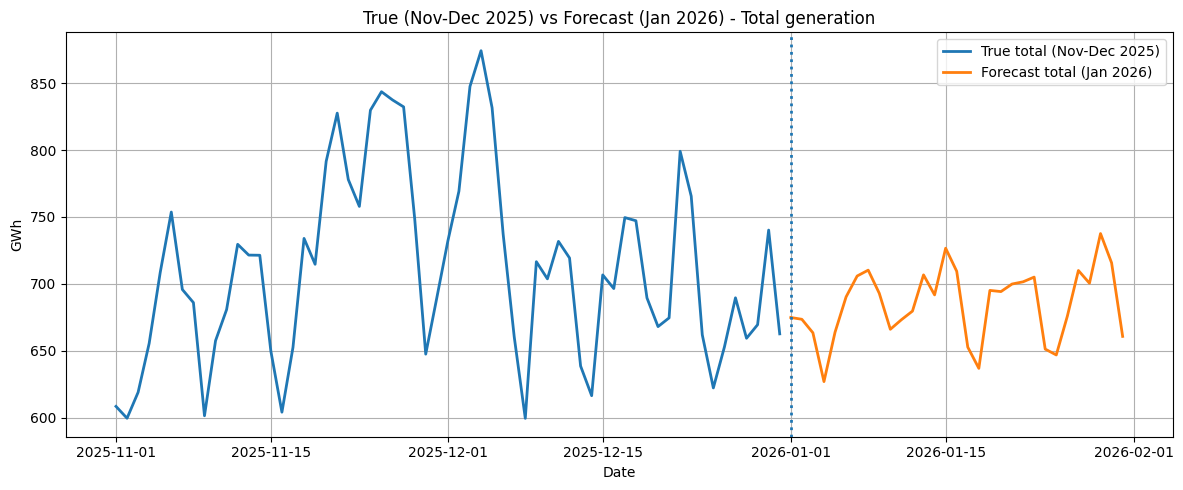

In [14]:
# Plot: Nov-Dec (true history) + Jan 2026 (forecast) 

#1 Build TOTAL true series (sum of the 7 technologies)
true_total = df_panel.groupby("ds")["y"].sum().sort_index()
true_total.index = pd.to_datetime(true_total.index)

#2 Build TOTAL forecast for Jan 2026 from out_fcst (sum of techs)
fc_total = (
    out_fcst.groupby("ds")["yhat"].sum()
    .sort_index()
    .to_frame("yhat")
)
fc_total.index = pd.to_datetime(fc_total.index)

#3 Choose the history window you want to show (Nov + Dec 2025)
hist_start = pd.Timestamp("2025-11-01")
hist_end   = pd.Timestamp("2025-12-31")

#4 Plot
plt.figure(figsize=(12,5))

# True history (Nov-Dec)
plt.plot(true_total.loc[hist_start:hist_end], linewidth=2, label="True total (Nov-Dec 2025)")

# Forecast (Jan 2026) 
plt.plot(fc_total.index, fc_total["yhat"],linewidth=2, label="Forecast total (Jan 2026)")

# Vertical line at Jan 1st
plt.axvline(pd.Timestamp("2026-01-01"), linestyle=":", linewidth=2)

plt.title("True (Nov-Dec 2025) vs Forecast (Jan 2026) - Total generation")
plt.xlabel("Date"); plt.ylabel("GWh")
plt.grid(True); plt.legend(); plt.tight_layout()
plt.show()


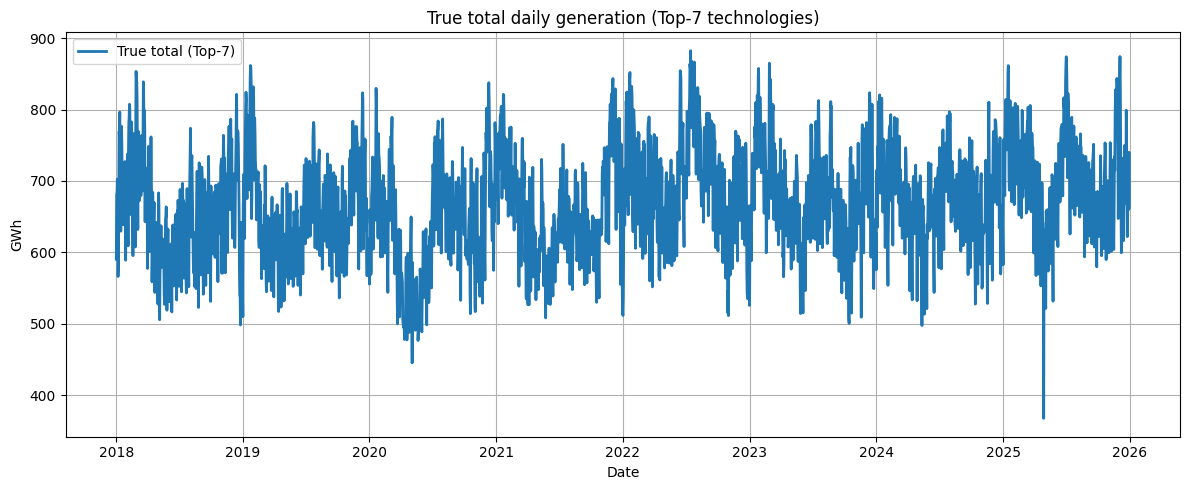

In [15]:
#plot full history
total_true = df_panel.groupby("ds")["y"].sum().sort_index()

plt.figure(figsize=(12,5))
plt.plot(total_true.index, total_true.values, linewidth=2, label="True total (Top-7)")
plt.title("True total daily generation (Top-7 technologies)")
plt.xlabel("Date")
plt.ylabel("GWh")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


TOTAL Jan 1-19 | MAE=100.55 GWh | RMSE=115.78 GWh | MAPE=12.72%


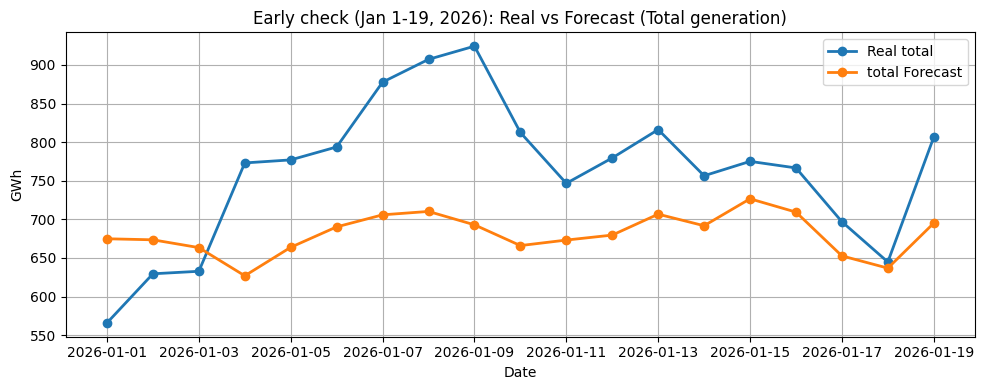

In [16]:
#1 Load forecast 

fc_path = Path("data/predictions/forecast_final_choice_jan2026.csv")
fc = pd.read_csv(fc_path)
fc["ds"] = pd.to_datetime(fc["ds"]).dt.normalize()


jan1 = pd.Timestamp("2026-01-01")
jan19 = pd.Timestamp("2026-01-19")
fc = fc[(fc["ds"] >= jan1) & (fc["ds"] <= jan19)].copy()


#2 Load real Jan file and convert wide->long (REE format)

def _parse_dates(dates):
    out = []
    for d in dates:
        s = str(d).strip()
        if "/" in s:
            out.append(pd.to_datetime(s.split()[0], dayfirst=True, errors="coerce"))
        else:
            out.append(pd.to_datetime(s[:10], errors="coerce"))
    return out

def ree_wide_to_long(path: Path) -> pd.DataFrame:
    raw = pd.read_csv(path, header=None, encoding="latin1")
    idx = raw.index[raw.iloc[:, 0].astype(str).str.strip().eq("Fecha")]
    r = idx[0]

    dates = _parse_dates(raw.iloc[r, 1:].tolist())

    data = raw.iloc[r+1:].dropna(how="all")
    data = data[data.iloc[:, 0].notna()]
    data.columns = ["unique_id"] + dates
    data["unique_id"] = data["unique_id"].astype(str).str.strip()
    data = data[data["unique_id"] != ""]

    df = data.melt(id_vars="unique_id", var_name="ds", value_name="y")
    df["ds"] = pd.to_datetime(df["ds"], errors="coerce").dt.normalize()

    # numbers: "-" missing, comma decimals, dot thousands
    y = df["y"].astype(str).str.strip().replace({"-": np.nan, "": np.nan})
    y = y.str.replace(".", "", regex=False).str.replace(",", ".", regex=False)
    df["y"] = pd.to_numeric(y, errors="coerce")

    df = df.dropna(subset=["unique_id", "ds", "y"])
    df["y"] = df["y"].clip(lower=0)
    return df[["unique_id", "ds", "y"]]

real_path = Path("data/real/REE-January.csv") 
real = ree_wide_to_long(real_path)

# keep only Jan 1..8
real = real[(real["ds"] >= jan1) & (real["ds"] <= jan19)].copy()

# keep only technologies that exist in forecast (Top-7)
real = real[real["unique_id"].isin(fc["unique_id"].unique())].copy()


#3 Merge forecast + real and build TOTAL daily series

cmp = real.rename(columns={"y": "y_true"}).merge(
    fc, on=["unique_id", "ds"], how="inner"
)

# TOTAL per day
daily = cmp.groupby("ds", as_index=False).agg(
    y_true=("y_true", "sum"),
    yhat=("yhat", "sum")
).sort_values("ds")

# metrics (TOTAL)
mae  = float(np.mean(np.abs(daily["y_true"] - daily["yhat"])))
rmse = float(np.sqrt(np.mean((daily["y_true"] - daily["yhat"])**2)))
mape = float(np.mean(np.abs((daily["y_true"] - daily["yhat"]) / (daily["y_true"] + 1e-9))) * 100)

print(f"TOTAL Jan 1-19 | MAE={mae:.2f} GWh | RMSE={rmse:.2f} GWh | MAPE={mape:.2f}%")


#4 plot (TOTAL)

plt.figure(figsize=(10,4))
plt.plot(daily["ds"], daily["y_true"], marker="o", linewidth=2, label="Real total")
plt.plot(daily["ds"], daily["yhat"], marker="o", linewidth=2, label="total Forecast")
plt.title("Early check (Jan 1-19, 2026): Real vs Forecast (Total generation)")
plt.xlabel("Date"); plt.ylabel("GWh")
plt.grid(True); plt.legend()
plt.tight_layout()
plt.show()
